In [1]:
# This code requires tensorflow 2.1.
# To check your version,

!pip3 show tensorflow

# For the purposes of running on Azure Notebooks, you may need to install it directly from the notebook.
#!pip install --upgrade tensorflow

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Name: tensorflow
Version: 2.1.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/dks28/.local/lib/python3.6/site-packages
Requires: google-pasta, grpcio, gast, astor, tensorboard, opt-einsum, protobuf, scipy, wrapt, keras-applications, tensorflow-estimator, six, wheel, numpy, termcolor, absl-py, keras-preprocessing
Required-by: 


In [2]:
import tensorflow.keras as keras
import tensorflow as tf
import pandas
import numpy as np
import matplotlib.pyplot as plt

tf.__version__

'2.1.0'

In [3]:
# These are some messy pieces of Python magic, to make interactive training of a neural network a little
# bit smoother. See the notes under Regression | Neural Network Model for how to use them.

import IPython
import signal

def interrupted(_interrupted=[False], _default=[None]):
    if _default[0] is None or signal.getsignal(signal.SIGINT) == _default[0]:
        _interrupted[0] = False
        def handle(signal, frame):
            if _interrupted[0] and _default[0] is not None:
                _default[0](signal, frame)
            print('Interrupt!')
            _interrupted[0] = True
        _default[0] = signal.signal(signal.SIGINT, handle)
    return _interrupted[0]

def enumerate_cycle(g):
    epoch = 0
    while True:
        for i,x in enumerate(g):
            yield (epoch,i), x
        epoch = epoch + 1

# Regression

Using the Housing dataset from practical 1, we'll try to predict `median_house_value` given the other features.

In [4]:
url = 'https://raw.githubusercontent.com/ekochmar/cl-datasci-pnp/master/DSPNP_practical1/housing/housing.csv'
housing = pandas.read_csv(url)

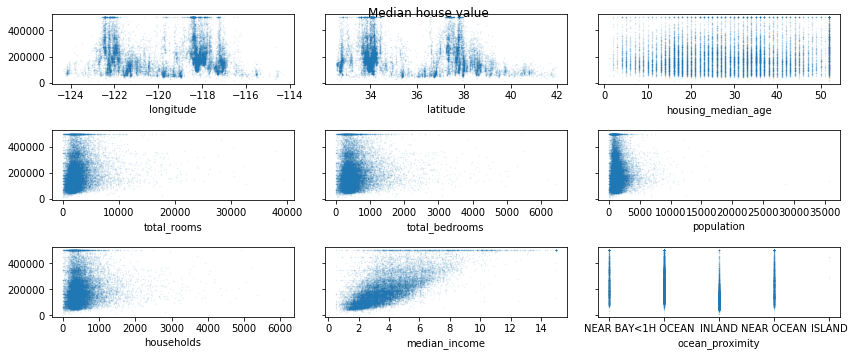

In [5]:
# Have a quick look at the data
# There isn't much to see, but it's good diligence, and it reminds us what data ranges there are

fig,axes = plt.subplots(3,3, sharey=True, figsize=(12,5))
axes = [a for axrow in axes for a in axrow]
cols = [col for col in housing.columns if col != 'median_house_value']
for col,ax in zip(cols, axes):
    ax.scatter(housing[col], housing.median_house_value, s=.2, alpha=.1)
    ax.set_xlabel(col)
fig.suptitle('Median house value')
fig.tight_layout()
plt.show()

### Data preparation

Produce a matrix X with shape (#records,#features), and a column Y with shape (#records).
Here Y is the median house value, and X contains all the other features

All the features are scaled to be within a reasonable range, to save the neural network some learning.

In [6]:
df = housing.copy()

# total_bedrooms has some missing values, so replace it with two columns: a mask, and a value
df['total_bedrooms_mask'] = np.where(pandas.isnull(housing.total_bedrooms), 0, 1)
df['total_bedrooms'] = np.where(pandas.isnull(housing.total_bedrooms), 0, housing.total_bedrooms)

# ocean_proximity is a categorical, so replace it by one-hot-coded version
for (suffix,level) in [('med','<1H OCEAN'), ('far','INLAND'), ('isle','ISLAND'), ('bay','NEAR BAY'), ('near','NEAR OCEAN')]:
    assert np.sum(housing.ocean_proximity==level) > 0, f"No values for {level}"
    df[f'ocean_prox_{suffix}'] = np.where(housing.ocean_proximity==level, 1, 0)
del df['ocean_proximity']

# Scale the columns, in a sane way depending on what they mean
for col in ['longitude','latitude']:
    df[col] = (df[col] - np.min(df[col])) / (np.max(df[col]) - np.min(df[col]))
for col in ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']:
    df[col] = (df[col] - np.mean(df[col])) / np.std(df[col])
    
X = df.drop('median_house_value', axis=1).values
Y = df.median_house_value.values

print(X.shape, Y.shape)

(20640, 14) (20640,)


### Neural network model

Keras has several ways of letting us specify a neural network model. Here I'm using the [functional API](https://keras.io/getting-started/functional-api-guide/), 
where you build up the neural network
as if you're programming imperatively.
Many of the pieces, e.g. `Dense`, come with their own set of parameters which Keras keeps track of, so that it can manage all the autograd updates by itself.

There's also a simpler [Sequential style](https://keras.io/getting-started/sequential-model-guide/), but it doesn't let you specify multiple inputs or multiple outputs. You could use it like this:
```
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=14, input_shape=(14,)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=8),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(units=1)
])
```

As well as specifying the model, we need to tell it what loss function to use. Here I'm using the mean square error, which is
```
def mse(y0, ypred):
    return tf.reduce_mean(tf.square(ypred - y0))
```
The loss function has to take two arguments. 
The first argument is typically the ground-truth response.
The second argument is a batch of outputs from your model. In this example, the model outputs a single value,
so `ypred` has shape `(batch_size,)`. 
If we have a multi-output model, it needs multiple loss functions. See the functional API documentation.

Finally we need to specify an optimizer. Don't get hung up on this!

**Training.** The core method is `model.train_on_batch(Xbatch, Ybatch)`, which executes an optimization step with the goal of minimizing the loss function we specified.
The two arguments are tensors whose first index enumerates the items within the batch. `Xbatch` is fed into the neural network,
and `Ybatch` is fed into the loss function. The return value is the value produced by our loss function.
(Or, we can specify extra metrics, to be computed each iteration. Then the return value is `[loss,metric1,metric2,...]`.)

I like to use some utilities (defined at the top of this notebook) to make interactive training a bit smoother.
First, I create a generator `eb_indexes` which returns an infinite list
```
[((epoch,batchnum),indexes), ...]
```
so I can keep training without worrying how long I need. Second, I use a special clause `while not interrupted()` which stops gracefully when you choose Kernel | Interrupt from the Jupyter menu. This is
an easy way to run the training, interrupt to play with the output, train some more, interrupt, ... (There is also Tensorboard, a much more heavyweight solution to monitoring.)

In [7]:
# Specify the neural network
# (You can also specify a list of inputs, or a list of outputs. See the docs.)

inputs = keras.layers.Input(shape=(14,))  # there are 14 features in X
x = keras.layers.Dense(14)(inputs)
x = keras.layers.ReLU()(x)
x = keras.layers.Dense(8)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.Dense(1)(x)
model = keras.models.Model(inputs=inputs, outputs=x)

model.compile(loss = keras.losses.mean_squared_error,
              optimizer = keras.optimizers.Adam()
              )

# Set up an endless iteration through epochs and batches of data
BATCH_SIZE = 20
indexes = np.arange(len(X))
indexes = np.array_split(indexes, len(X) / BATCH_SIZE)
eb_indexes = enumerate_cycle(indexes)

# Accumulate some stats as we go along
loss_history = []

In [8]:
while not interrupted():
    (epoch,batch),i = next(eb_indexes)
    loss = model.train_on_batch(X[i], Y[i])
    if batch % 100 == 0:
        IPython.display.clear_output(wait=True)
        print(f'loss={loss} epoch={epoch} batchnum={batch}/{len(indexes)}')
        loss_history.append((epoch+batch/len(indexes), loss))

loss=0.3522343039512634 epoch=24 batchnum=0/1032
Interrupt!


Final training loss: 0.2015720555189622


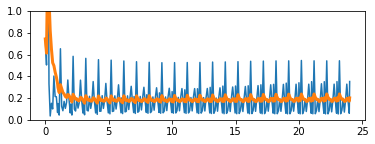

In [9]:
# Simple plot of the training loss
df = pandas.DataFrame.from_records(loss_history, columns=['epoch','loss'])
print("Final training loss:", df.loss.ewm(com=5).mean().iloc[-1])
fig,ax = plt.subplots(figsize=(6,2))
ax.plot(df.epoch, df.loss)
ax.plot(df.epoch, df.loss.ewm(com=5).mean(), linewidth=3)
ax.set_ylim([0,1])
plt.show()

# Unsupervised learning of sequences

In [31]:
names = pandas.read_table('../../data/english_names.txt', header=None, names=['X']).sample(frac=1).X.str.lower()

To make life simple, this code only works with "batches" of size 1.
If we wanted to work with longer batches, we'd have to take care with
batches whose entries all have different input_length (i.e. number of
characters in the name).

The input to the model is a name, with shape `(batch_size=1, input_length=#chars+2, alphabet=27)`
The name includes a padding of 0 on either end.
Letters are coded as 1..26, and start-of-name and end-of-name are 0.
And then they're all one-hot encoded.
The model computes the log likelihood of this name.

In addition, the model outputs the computed probabilities `p`. During playback, 
we want to use these to synthesize characters in a new (random) name.
Therefore I've made this a multi-output model, which outputs both the log likelihood 
and the probabilities.

**A note on keras terminology.** As described in the lecture, a RNN consists of a sequence of functions $f_\theta : (x_j,h_j) \mapsto (p_{j+1},h_{j+1})$.
The particular $f_\theta$ that we're using here is a stack, consisting of a GRU cell, another GRU cell, then a Dense cell, and softmax.
The keras GRU layer is actually a full _sequence_ of GRU cells,
one for each index $j$, all sharing the same parameters $\theta$. Thus the GRU layer accepts as input the sequence $(x_0,\dots,x_{n-1})$, and 
produces a sequence of probability vectors $(p_1,\dots,p_n)$. We don't actually see the hidden $h_j$ values at all (unless we ask for them explicitly).

In [32]:
inputs = keras.layers.Input(shape=(None,27))
x = keras.layers.GRU(units=50, return_sequences=True)(inputs[:,:-1,:])
x = keras.layers.GRU(units=50, return_sequences=True)(x)
x = keras.layers.Dense(27)(x)
p = keras.activations.softmax(x)
nloglik = tf.reduce_sum(keras.losses.categorical_crossentropy(inputs[:,1:,:], p), axis=1)
model = keras.models.Model(inputs=inputs, outputs=[nloglik,p])

# This is unsupervised learning -- there's no "true label". So the y0 argument is ignored.
# This is a multi-output model, so it needs a loss function for each output.
# The dummy loss function just makes it ignore the second output.
def myloss(y0, nloglik_batch): return tf.reduce_mean(nloglik_batch)
def dummyloss(y0, ypred): return 0.0

model.compile(loss = [myloss, dummyloss],
              loss_weights = [1.0, 0.0],
              optimizer = keras.optimizers.Adam())

To generate a new name, we'd like to use a single trained GRU cell, and call it iteratively to generate a new name character by character. There's no obvious way to do this ... all we have access to is the `model` which accepts and entire name and computes probabilities for every letter in it. To get around this, we can use the following trick. Suppose we've generated the name "dam". Feed this name into the model, and it will output three probability vectors, the last one of which predicts the character after "m". We'll generate a new character from this probability vector, say "o".
Then we can feed "damo" into the model, and ask for the next character. And so on, until we hit the end-of-name symbol.

In [33]:
def gen_name():
    name = ''
    while True:
        name_n = [0] + [ord(x) - ord('a') + 1 for x in list(name) if x>='a' and x<='z'] + [0]
        name_oh = keras.utils.to_categorical(name_n, num_classes=27) 
        _,ps = model(name_oh[np.newaxis,:,:])
        p = ps[0]  # batch of size 1
        lastp = p[-1].numpy()  # output probabilities for the final character
        lastp = lastp / sum(lastp)  # there are some small rounding errors for float32
        char_n = np.random.choice(np.arange(27), p=lastp)
        if char_n == 0:
            break
        name = name + chr(char_n + ord('a') - 1)
    return name

In [34]:
names_n = [[0] + [ord(x) - ord('a') + 1 for x in list(name) if x>='a' and x<='z'] + [0] for name in names]
names_oh = [keras.utils.to_categorical(n, num_classes=27) for n in names_n]
ei_names = enumerate_cycle(names_oh)

loss_history = []

In [42]:
while not interrupted():
    (epoch,item),name = next(ei_names)
    loss = model.train_on_batch(name[np.newaxis,:,:], [[0.0],[0.0]])
    if item % 100 == 0:
        IPython.display.clear_output(wait=True)
        print(f'loss={loss} epoch={epoch} item={item}/{len(names)} name={gen_name()}')
        loss_history.append((epoch+item/len(names), loss[0]))

loss=[9.642064, 9.642064, 0.0] epoch=36 item=2600/3668 name=farch
Interrupt!


Final training loss: 10.189478666658776


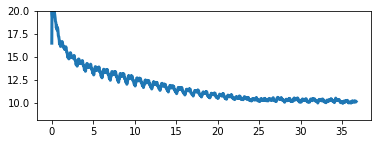

In [43]:
# Simple plot of the training loss
df = pandas.DataFrame.from_records(loss_history, columns=['epoch','loss'])
print("Final training loss:", df.loss.ewm(com=20).mean().iloc[-1])
fig,ax = plt.subplots(figsize=(6,2))
ax.plot(df.epoch, df.loss.ewm(com=20).mean(), linewidth=3)
ax.set_ylim([np.log(len(names)), 20])
plt.show()

In [44]:
# This RNN has not learnt terribly well: it fixates on the last few names it saw.
# We shouldn't have trained it in order on a sorted list of names!

for _ in range(10): print(gen_name())

goddell
lope
lyus
whiteby
whatey
turren
fabsed
elyman
frankland
robert


ValueError: invalid literal for int() with base 10: 'A'